<div id="reminder" style="border-radius: 5px; background-color:#f5f5f5; padding: 15px 5px; " >
<p>Use this notebook to follow along with the lab tutorial.</p>
</div>

# <font color="blue">Lesson 4 Feature Engineering and Selection</font>

## Section 1 Handling Categorical Variables

### Read Data from CSV File

In [1]:
import pandas as pd
file = "Tennis.csv"
data = pd.read_csv(file, header=0)
data.head()

,outlook,temp,humidity,windy,play
0,sunny,hot,high,strong,no
1,sunny,hot,high,weak,no
2,overcast,hot,high,weak,yes
3,rain,mild,high,weak,yes
4,rain,cool,normal,weak,yes


### One Hot Encoding

In [2]:
import category_encoders as ce
X = data[["outlook","temp","humidity","windy"]]
le =  ce.OneHotEncoder(return_df=False,handle_missing=False,handle_unknown="ignore")
X_encoded = le.fit_transform(X)
X_encoded[0:5,:]

array([[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]])

In [3]:
# print out the category mapping
le.category_mapping

[{'col': 'outlook', 'mapping': sunny       1
  overcast    2
  rain        3
  NaN        -2
  dtype: int64, 'data_type': dtype('O')}, {'col': 'temp', 'mapping': hot     1
  mild    2
  cool    3
  NaN    -2
  dtype: int64, 'data_type': dtype('O')}, {'col': 'humidity',
  'mapping': high      1
  normal    2
  NaN      -2
  dtype: int64,
  'data_type': dtype('O')}, {'col': 'windy', 'mapping': strong    1
  weak      2
  NaN      -2
  dtype: int64, 'data_type': dtype('O')}]

### One-hot Encoding by Pandas

In [4]:
import pandas as pd
data_encoded = pd.get_dummies(data, columns=["outlook","temp","humidity","windy"], \
                             prefix=["outlook","temp","humdity","windy"])
data_encoded.head()

,play,outlook_overcast,outlook_rain,outlook_sunny,temp_cool,temp_hot,temp_mild,humdity_high,humdity_normal,windy_strong,windy_weak
0,no,0,0,1,0,1,0,1,0,1,0
1,no,0,0,1,0,1,0,1,0,0,1
2,yes,1,0,0,0,1,0,1,0,0,1
3,yes,0,1,0,0,0,1,1,0,0,1
4,yes,0,1,0,1,0,0,0,1,0,1


### References for More Complete List of One-hot Encoding Methodologies

Moffitt, C. (2017) <a href="http://pbpython.com/categorical-encoding.html">Guide to Encoding Categorical Values in Python</a>, Practical Business Python.

### Risk Values of Categorical Variables

In [5]:
import numpy as np
General_Prob = (data.iloc[:,4] == "yes").sum()/float(data.shape[0])
variable_risks = {}
for variable in ['outlook', 'temp', 'humidity', 'windy']:
    tab = pd.crosstab(data[variable], data.play) #Create a contingency table
    print(tab)
    num_levels = tab.shape[0]
    level_risk = {}
    levels = list(tab.index)
    level_index = 0
    for lev in levels:
        if lev == True:
            lev = 'True'
        elif lev == False:
            lev = 'False'
        # general_prob is used as asmooth parameters when calculating risk values
        level_risk[lev] = np.log((tab.iloc[level_index, 1] + General_Prob) / (tab.iloc[level_index, 0] + 1 - General_Prob))
        level_index += 1
    variable_risks[variable] = level_risk
print(variable_risks)

play      no  yes
outlook          
overcast   0    4
rain       2    3
sunny      3    2
play  no  yes
temp         
cool   1    3
hot    2    2
mild   2    4
play      no  yes
humidity         
high       4    3
normal     1    6
play    no  yes
windy          
strong   3    3
weak     2    6
{'outlook': {'overcast': 2.564949357461537, 'rain': 0.4353180712578455, 'sunny': -0.23922968906583425}, 'temp': {'cool': 0.9873866535578852, 'hot': 0.11441035117774412, 'mild': 0.6778797084291569}, 'humidity': {'high': -0.17904823144898543, 'normal': 1.5881605139868153}, 'windy': {'strong': 0.0816780310142671, 'weak': 1.0360919316867758}}


### Replace the Original Categorical Values with Risks

In [6]:
data_risks = data.copy()
# data_risks.windy = data_risks.windy.astype(float)
num_obs = data.shape[0]
for variable in ['outlook', 'temp', 'humidity', 'windy']:
    for i in range(num_obs):
        if data[variable][i] == True:
            lev = 'True'
        elif data[variable][i] == False:
            lev = 'False'
        else:
            lev = data[variable][i]
        data_risks[variable][i] = variable_risks[variable][lev]
data_risks.head()

,outlook,temp,humidity,windy,play
0,-0.23923,0.11441,-0.179048,0.081678,no
1,-0.23923,0.11441,-0.179048,1.03609,no
2,2.56495,0.11441,-0.179048,1.03609,yes
3,0.435318,0.67788,-0.179048,1.03609,yes
4,0.435318,0.987387,1.58816,1.03609,yes


## Section 2. Recency, Frequency, and Monetary (RFM)

### Read Example Data

In [7]:
import pandas as pd
file = "Retail_Churn_Data.csv"
data = pd.read_csv(file, sep=",", header=0)
data.head()

,UserId,Age,Address,Column 0,TransactionId,Timestamp,ItemId,Quantity,Value
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


### Convert Timestamp to Datetime Object

In [8]:
import datetime as dt
import pandas as pd
import numpy as np
from collections import OrderedDict

data["Timestamp"] = pd.to_datetime(data["Timestamp"], format='%m/%d/%Y %H:%M')
data.head()
print("Minimal Date=%s, Maximal Date=%s"%(min(data["Timestamp"]).strftime("%Y-%m-%d %H:%M"), \
                                          max(data["Timestamp"]).strftime("%Y-%m-%d %H:%M")))



Minimal Date=2000-11-01 00:00, Maximal Date=2001-02-28 00:00


### Calculate RFM Features for Users at Each Checkpoint

In [9]:
Start_Date_Obj = dt.datetime.strptime("1/1/2001", "%m/%d/%Y")
End_Date_Obj = dt.datetime.strptime("1/10/2001", "%m/%d/%Y")
Time_Window = 60 #days. Only consider customers who have activities within the recent 60 days
FM_Window = 7 #days for frequency and monetary

check_point_date = Start_Date_Obj
UserID = []
Checkpoint = []
Recency = []
Frequency = []
Monetary_Value = []
Monetary_Quantity = []
while check_point_date <= End_Date_Obj:
    window_start = check_point_date - dt.timedelta(days = Time_Window)
    mask = (data["Timestamp"] >= window_start) & (data["Timestamp"] < check_point_date)
    # Get the data in [checkpoint-60days, checkpoint]
    data_checkpoint = data.loc[mask]
    # Get the ids of users who have activities in [checkpoint-60days, checkpoint]
    unique_users = list(set(data_checkpoint["UserId"]))
    print("There are %d unique users."%(len(unique_users)))
    FM_Window_Start = check_point_date - dt.timedelta(days = FM_Window)
    for user in unique_users:
        UserID.append(user)
        Checkpoint.append(check_point_date)
        mask = data_checkpoint["UserId"] == user
        data_checkpoint_user = data_checkpoint.loc[mask]
        delta = check_point_date - max(data_checkpoint_user["Timestamp"])
        recency = delta.days #Recency, days between checkpoint and last transaction time
        mask = data_checkpoint_user["Timestamp"] >= FM_Window_Start
        data_checkpoint_user_fm = data_checkpoint_user.loc[mask]
        frequency = data_checkpoint_user_fm.shape[0]
        value = np.sum(data_checkpoint_user_fm.iloc[:, 8]) #monetary values
        quantity = np.sum(data_checkpoint_user_fm.iloc[:, 7])#monetary quantity
        Recency.append(recency)
        Frequency.append(frequency)
        Monetary_Value.append(value)
        Monetary_Quantity.append(quantity)
    check_point_date = check_point_date + dt.timedelta(days = 1)
# Consolidate all columns into a signle data frame
RFM_Dict = OrderedDict([ ('UserID', UserID),
          ('Checkpoint', Checkpoint),
          ('Recency',  Recency),
          ('Frequency', Frequency),
          ('Value', Monetary_Value),
          ('Quantity', Monetary_Quantity)] )
RFM_Frame = pd.DataFrame.from_dict(RFM_Dict)
RFM_Frame.head()


There are 7275 unique users.
There are 7333 unique users.
There are 7347 unique users.
There are 7287 unique users.
There are 7203 unique users.
There are 7165 unique users.
There are 7152 unique users.
There are 7159 unique users.
There are 7153 unique users.
There are 7132 unique users.


,UserID,Checkpoint,Recency,Frequency,Value,Quantity
0,2162690,2001-01-01,29,0,0,0
1,425995,2001-01-01,2,2,92,3
2,1835021,2001-01-01,15,0,0,0
3,589840,2001-01-01,5,8,1316,9
4,2162706,2001-01-01,26,0,0,0


# Feature Selection LESSON 04

## Section 3. Filter-based Selection

### Mutual Information

In [10]:
import numpy as np

X = np.linspace(start = -1, stop = 3, num=401, endpoint=True)
Y = X**2 - 2*X + 1
print("Standard Deviation of Y=%.2f"%np.std(Y))

noise_var = 0.1
noise = np.random.normal(0, noise_var, len(X))
Y += noise
#Y = noise

import matplotlib.pyplot as plt

plt.plot(X, Y)
plt.show()

# Calculation Correlation
corr = np.corrcoef(X, Y)[0, 1]
print("Correlation between X and Y is %.2f"%corr)
# Calculate Mutual Information

from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi = calc_MI(X, Y, 20)
print("Mutual information=%.2f"%mi)

Standard Deviation of Y=1.20


<Figure size 640x480 with 1 Axes>

Correlation between X and Y is 0.00
Mutual information=1.76


## Section 4. Stepwise and Embedded Methods

### Stepwise Model Selection

#### Backward model selection

In [18]:
# Recursive Feature Elimination
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE #Recursive Feature Elimination
from sklearn.linear_model import LinearRegression
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
#print(X[0:10,:]) # print out the first 10 rows
estimator = LinearRegression()
selector = RFE(estimator, 5, step=1)#select 5 features. Step=1 means each step only remove 1 variable from the model
selector = selector.fit(X, y)
print(selector.support_) # The mask of selected features.
print(selector.ranking_) # selected features are ranked 1. The 6th is the one that is removed first,
                         # 2nd is the one that is removed last

[ True  True  True  True  True False False False False False]
[1 1 1 1 1 2 3 6 5 4]


C:\Users\ly266e\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [21]:
# print(y) # print out the first 10 rows

[17.2134918  19.37965436 14.75030901 11.81662128  9.45520588 13.90806032
  3.40447398 24.20228984 17.5783377  17.51556532 17.40999895 17.11893656
 21.81510702 15.88623898 21.63246599 13.01689624 22.908266    6.84202611
 10.32969753 17.70617001  8.52251585  9.51592807 19.81663198  2.99416378
  8.04688453 22.09060713 18.07976383 15.64717616  9.18985112  8.10886643
 11.46237964 11.27510587  9.39472899 19.12963765  6.75303583  8.59450992
 14.08547252 15.47556192 23.37684908 10.65602456 26.21981092  7.56662861
  6.09081028 15.3507226  13.30251573 15.05111884 12.18062778 23.69853054
  7.89988206 14.86941989]


### Install Machine Learning Extensions
See <a href="http://rasbt.github.io/mlxtend/">mlxtend's documentation</a>

In [17]:
# # Uncomment the following line to run
# !pip install mlxtend

#### Forward Feature Selection

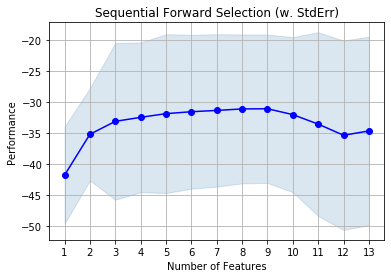

In [13]:
# Forward Stepwise Feature Selection
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

boston = load_boston()
X, y = boston.data, boston.target

#print(X[0:10, :])
lr = LinearRegression()

sfs = SFS(lr, 
          k_features=13, # k_features has to be smaller or equal to the number of features. If equal to, it starts from
                         # intercept to the full model
          forward=True,  # forward
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

### Get the Best Model

In [14]:
sfs.get_metric_dict()[8]

{'feature_idx': (0, 1, 3, 4, 5, 7, 10, 12),
 'cv_scores': array([  -9.72892743,  -14.58689072,  -12.01189155,  -37.33502852,
         -30.34743059,  -21.26868648,   -9.78483232, -135.22686925,
         -30.70389754,  -10.60860571]),
 'avg_score': -31.160306011122838,
 'feature_names': ('0', '1', '3', '4', '5', '7', '10', '12'),
 'ci_bound': 26.723857597320013,
 'std_dev': 35.98140785582496,
 'std_err': 11.993802618608319}

### LASSO and Ridge Regression

In [15]:
# LASSO
from sklearn import linear_model

alpha = 0.5 # Increasing alpha can shrink more variable coefficients to 0
clf = linear_model.Lasso(alpha=alpha)
clf.fit(X, y)

print(clf.coef_)

print(clf.intercept_)



[-0.0832894   0.04954355 -0.0052532   0.         -0.          2.49821246
  0.00360438 -0.93660469  0.27745115 -0.01544219 -0.75875211  0.00946855
 -0.6562895 ]
32.520860962576535


In [16]:
# Ridge Regression
from sklearn import linear_model
alpha = 10 
clf = linear_model.Ridge(alpha=alpha)
clf.fit(X, y)

print(clf.coef_)

print(clf.intercept_)

import numpy as np
# Increasing alpha can compress the L2 norm of the coefficients to 0 (but not selecting variables)
print("Sum of square of coefficients = %.2f"%np.sum(clf.coef_**2)) 

[-0.10143535  0.0495791  -0.0429624   1.95202082 -2.37161896  3.70227207
 -0.01070735 -1.24880821  0.2795956  -0.01399313 -0.79794498  0.01003684
 -0.55936642]
27.467884964141238
Sum of square of coefficients = 25.74


<div id="reminder" style="border-radius: 5px; background-color:#f5f5f5; padding: 15px 5px; " >
<p>For additional practice, please see the Workshop notebooks.</p>
</div>